In [1]:
# import required libraries for dataframe and visualization

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# import required libraries for clustering
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score
from kmodes.kprototypes import KPrototypes

In [2]:
# Read in all orders.
orders = pd.read_csv('superstore_dataset2011-2015.csv', header=0, encoding='ISO-8859-1')

In [3]:
# Display dataset's data types.
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Row ID          51290 non-null  int64  
 1   Order ID        51290 non-null  object 
 2   Order Date      51290 non-null  object 
 3   Ship Date       51290 non-null  object 
 4   Ship Mode       51290 non-null  object 
 5   Customer ID     51290 non-null  object 
 6   Customer Name   51290 non-null  object 
 7   Segment         51290 non-null  object 
 8   City            51290 non-null  object 
 9   State           51290 non-null  object 
 10  Country         51290 non-null  object 
 11  Postal Code     9994 non-null   float64
 12  Market          51290 non-null  object 
 13  Region          51290 non-null  object 
 14  Product ID      51290 non-null  object 
 15  Category        51290 non-null  object 
 16  Sub-Category    51290 non-null  object 
 17  Product Name    51290 non-null 

In [4]:
# Dsiplay the dataset's number of rows and columns pre-formatting
orders.shape

(51290, 24)

In [5]:
# Display the dataset's basic stat.
orders.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit,Shipping Cost
count,51290.00000,9994.000000,51290.000000,51290.000000,51290.000000,51290.000000,51290.000000
mean,25645.50000,55190.379428,246.490581,3.476545,0.142908,28.610982,26.375915
std,14806.29199,32063.693350,487.565361,2.278766,0.212280,174.340972,57.296804
min,1.00000,1040.000000,0.444000,1.000000,0.000000,-6599.978000,0.000000
25%,12823.25000,23223.000000,30.758625,2.000000,0.000000,0.000000,2.610000
50%,25645.50000,56430.500000,85.053000,3.000000,0.000000,9.240000,7.790000
75%,38467.75000,90008.000000,251.053200,5.000000,0.200000,36.810000,24.450000
max,51290.00000,99301.000000,22638.480000,14.000000,0.850000,8399.976000,933.570000


In [6]:
# Checking for null fields
df_null = round(100*(orders.isnull().sum())/len(orders), 2)
df_null

Row ID             0.00
Order ID           0.00
Order Date         0.00
Ship Date          0.00
Ship Mode          0.00
Customer ID        0.00
Customer Name      0.00
Segment            0.00
City               0.00
State              0.00
Country            0.00
Postal Code       80.51
Market             0.00
Region             0.00
Product ID         0.00
Category           0.00
Sub-Category       0.00
Product Name       0.00
Sales              0.00
Quantity           0.00
Discount           0.00
Profit             0.00
Shipping Cost      0.00
Order Priority     0.00
dtype: float64

In [7]:
# Drop Postal Code, since 80% of this column's data is missing
orders = orders.drop(columns=['Postal Code'])

In [8]:
orders = orders.dropna()

# Check the shape after dropping the rows with missing values
orders.shape

(51290, 23)

In [9]:
# Monetary column
rfm_m = orders.groupby('Customer ID')['Sales'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.columns = ['Customer ID', 'Sales']
rfm_m.head()

,Customer ID,Sales
0,AA-10315,13747.41300
1,AA-10375,5884.19500
2,AA-10480,17695.58978
3,AA-10645,15343.89070
4,AA-315,2243.25600


In [104]:
# Frequency column
rfm_f = orders.groupby('Customer ID')['Order ID'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['Customer ID', 'Frequency']
rfm_f.head()

,Customer ID,Frequency
0,AA-10315,42
1,AA-10375,42
2,AA-10480,38
3,AA-10645,73
4,AA-315,8


In [105]:
# Recency column
orders['Order Date'] = orders['Order Date'].str.replace('/', '-')
orders['Order Date']


0          1-1-2011
1          1-1-2011
2          1-1-2011
3          1-1-2011
4          1-1-2011
            ...    
51285    31-12-2014
51286    31-12-2014
51287    31-12-2014
51288    31-12-2014
51289    31-12-2014
Name: Order Date, Length: 51290, dtype: object

In [106]:
orders['Order Date'] = pd.to_datetime(orders['Order Date'],format='%d-%m-%Y')
orders['Order Date']

0       2011-01-01
1       2011-01-01
2       2011-01-01
3       2011-01-01
4       2011-01-01
           ...    
51285   2014-12-31
51286   2014-12-31
51287   2014-12-31
51288   2014-12-31
51289   2014-12-31
Name: Order Date, Length: 51290, dtype: datetime64[ns]

In [107]:
max_date = max(orders['Order Date'])
max_date

Timestamp('2014-12-31 00:00:00')

In [108]:
orders['Diff'] = max_date - orders['Order Date']
rfm_r = orders.groupby('Customer ID')['Diff'].min()
rfm_r = rfm_r.reset_index().sort_values(by='Diff', ascending=False)
rfm_r['Diff'] = rfm_r['Diff'].dt.days
rfm_r

,Customer ID,Diff
431,DK-2985,1206
484,DW-3195,1063
1460,SZ-10035,956
850,KD-6270,811
365,CT-1995,783
...,...,...
871,KL-6645,0
872,KM-16225,0
680,JA-15970,0
939,LP-7095,0


In [109]:
# Merging dataframes
rfm = pd.merge(rfm_m, rfm_f, on='Customer ID', how='inner')
rfm = pd.merge(rfm, rfm_r, on='Customer ID', how='inner')
rfm.columns = ['Customer ID', 'Amount', 'Frequency', 'Recency']
rfm.head()

,Customer ID,Amount,Frequency,Recency
0,AA-10315,13747.41300,42,8
1,AA-10375,5884.19500,42,6
2,AA-10480,17695.58978,38,125
3,AA-10645,15343.89070,73,28
4,AA-315,2243.25600,8,2


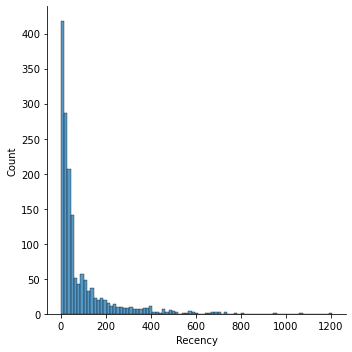

In [110]:
# Distribution for Recency
sns.displot(rfm['Recency'])

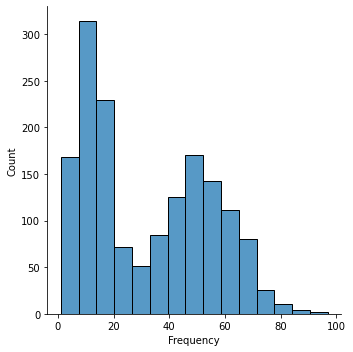

In [111]:
# Distribution for Frequency
sns.displot(rfm['Frequency'])

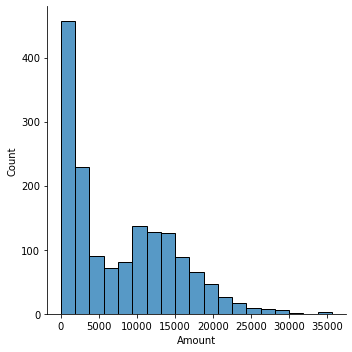

In [112]:
# Distribution for Amount
sns.displot(rfm['Amount'])

Text(0.5, 0, 'Attributes')

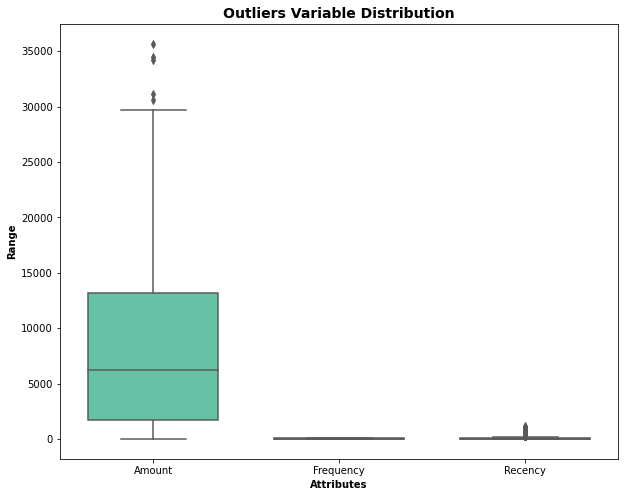

In [113]:
# Detect outliers

attributes = ['Amount','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [114]:
# Removing (statistical) outliers for Amount
Q1 = rfm.Amount.quantile(0.25)
Q3 = rfm.Amount.quantile(0.75)
IQR = Q3 - Q1
rfm = rfm[(rfm.Amount >= Q1 - 1.5*IQR) & (rfm.Amount <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Recency
Q1 = rfm.Recency.quantile(0.25)
Q3 = rfm.Recency.quantile(0.75)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Frequency
Q1 = rfm.Frequency.quantile(0.25)
Q3 = rfm.Frequency.quantile(0.75)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

Text(0.5, 0, 'Attributes')

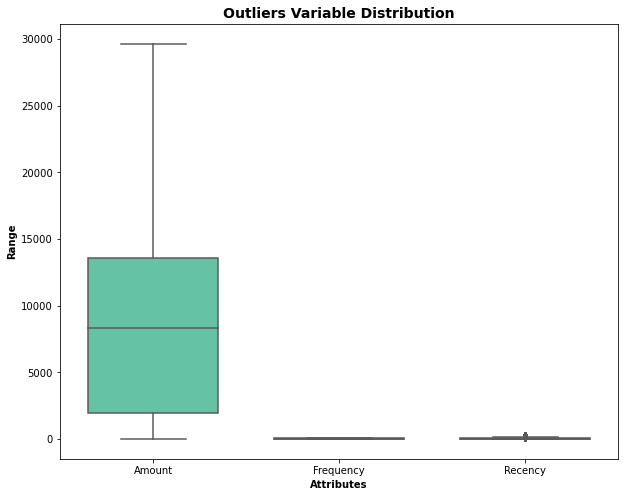

In [115]:
attributes = ['Amount','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

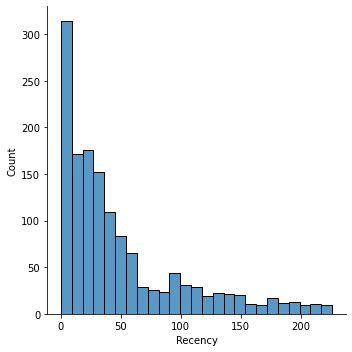

In [116]:
# Distribution for Recency
sns.displot(rfm['Recency'])

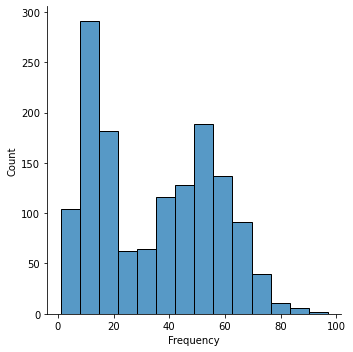

In [117]:
# Distribution for Frequency
sns.displot(rfm['Frequency'])

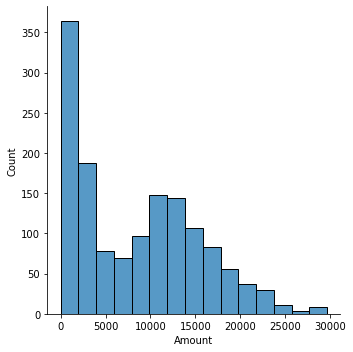

In [118]:
# Distribution for Amount
sns.displot(rfm['Amount'])

In [119]:
# Rescaling the attributes

rfm_df = rfm[['Amount', 'Frequency', 'Recency']]

# Instantiate
scaler = MinMaxScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(1423, 3)

In [120]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()

,Amount,Frequency,Recency
0,0.463304,0.427083,0.035398
1,0.198166,0.427083,0.026549
2,0.596432,0.385417,0.553097
3,0.517136,0.750000,0.123894
4,0.075398,0.072917,0.008850


In [121]:
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [122]:
kmeans.labels_

array([1, 1, 1, ..., 3, 0, 1])

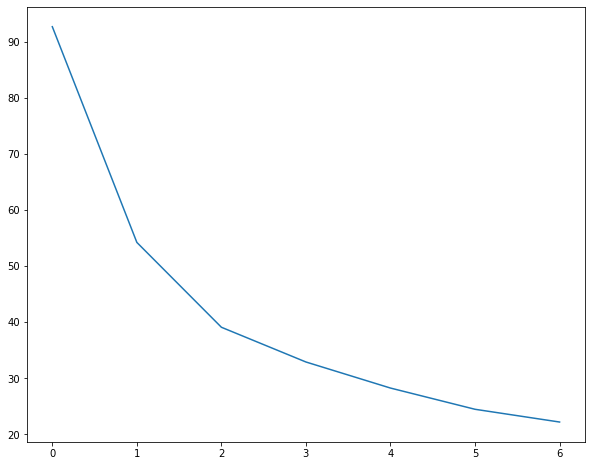

In [123]:
# Elbow-curve/SSD (Sum of Squares Distance)

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)
# y-axis: SSD
# x-axis: Number of clusters
# Choose a balance point to avoid over-fitting.

In [124]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    
# The higher the point, the higher similarities between items within a cluster and 
# the higher dissimilarites bettwen items in different clusters.
# Choose a balance number to avoid over-fitting.

For n_clusters=2, the silhouette score is 0.5211722951221243
For n_clusters=3, the silhouette score is 0.5229832676402274
For n_clusters=4, the silhouette score is 0.4448551021692008
For n_clusters=5, the silhouette score is 0.4226944381574405
For n_clusters=6, the silhouette score is 0.41504544677728317
For n_clusters=7, the silhouette score is 0.3837157686097956
For n_clusters=8, the silhouette score is 0.3653730719803394


In [125]:
# Final model with k=4
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [126]:
kmeans.labels_

array([1, 1, 1, ..., 2, 0, 1])

In [127]:
# assign the label
rfm['Cluster_Id'] = kmeans.labels_
rfm.head()

,Customer ID,Amount,Frequency,Recency,Cluster_Id
0,AA-10315,13747.41300,42,8,1
1,AA-10375,5884.19500,42,6,1
2,AA-10480,17695.58978,38,125,1
3,AA-10645,15343.89070,73,28,2
4,AA-315,2243.25600,8,2,0


<AxesSubplot:xlabel='Cluster_Id', ylabel='Amount'>

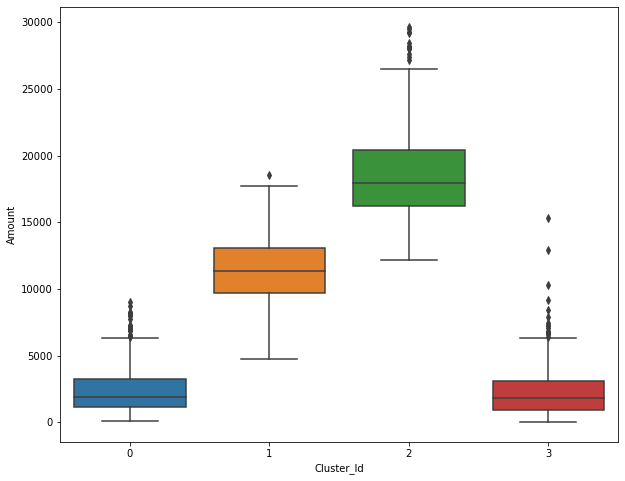

In [128]:
# Box plot to visualize Cluster Id vs Amount

sns.boxplot(x='Cluster_Id', y='Amount', data=rfm)

<AxesSubplot:xlabel='Cluster_Id', ylabel='Recency'>

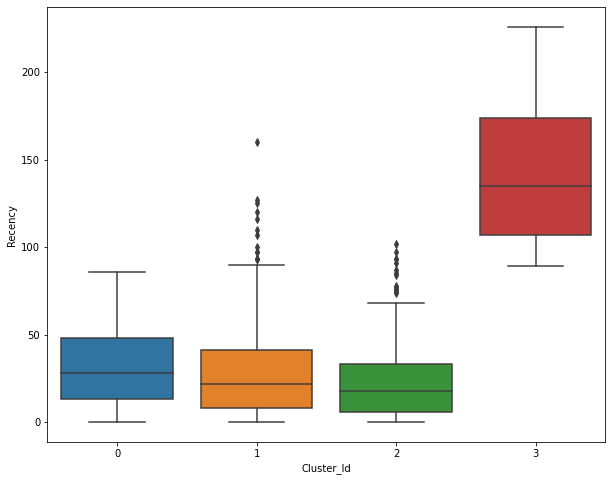

In [129]:
# Box plot to visualize Cluster Id vs Recency

sns.boxplot(x='Cluster_Id', y='Recency', data=rfm)

<AxesSubplot:xlabel='Cluster_Id', ylabel='Frequency'>

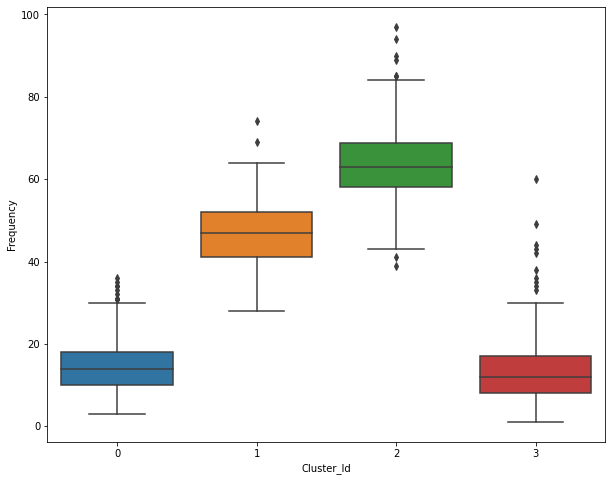

In [130]:
# Box plot to visualize Cluster Id vs Frequency

sns.boxplot(x='Cluster_Id', y='Frequency', data=rfm)

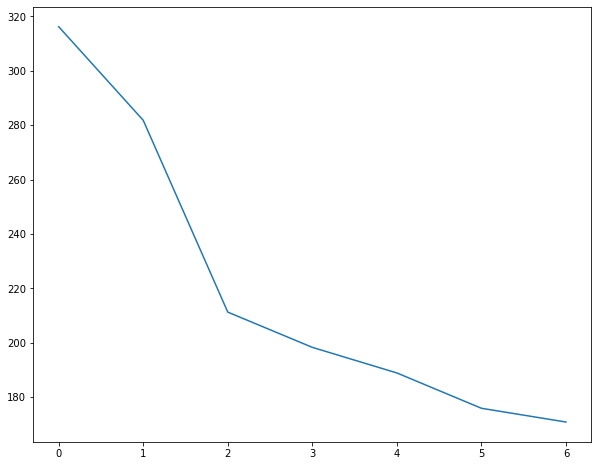

In [131]:
# Elbow-curve/SSD (Sum of Squares Distance)

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmedoids = KMedoids(n_clusters=num_clusters, max_iter=50)
    kmedoids.fit(rfm_df_scaled)
    
    ssd.append(kmedoids.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)
# y-axis: SSD
# x-axis: Number of clusters
# Choose a balance point to avoid over-fitting.

In [132]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmedoids = KMedoids(n_clusters=num_clusters, max_iter=50)
    kmedoids.fit(rfm_df_scaled)
    
    cluster_labels = kmedoids.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    
# The higher the point, the higher similarities between items within a cluster and 
# the higher dissimilarites bettwen items in different clusters.
# Choose a balance number to avoid over-fitting.

For n_clusters=2, the silhouette score is 0.5203913617673406
For n_clusters=3, the silhouette score is 0.35056745328219496
For n_clusters=4, the silhouette score is 0.4309509845681114
For n_clusters=5, the silhouette score is 0.37216896905396346
For n_clusters=6, the silhouette score is 0.2940485549059837
For n_clusters=7, the silhouette score is 0.32020276863738933
For n_clusters=8, the silhouette score is 0.3012085516779093


In [133]:
# Final model with k=4
kmedoids = KMedoids(n_clusters=4, max_iter=50)
kmedoids.fit(rfm_df_scaled)

KMedoids(max_iter=50, n_clusters=4)

In [134]:
# assign the label
rfm['Cluster_Id'] = kmedoids.labels_
rfm.head()

,Customer ID,Amount,Frequency,Recency,Cluster_Id
0,AA-10315,13747.41300,42,8,0
1,AA-10375,5884.19500,42,6,0
2,AA-10480,17695.58978,38,125,1
3,AA-10645,15343.89070,73,28,1
4,AA-315,2243.25600,8,2,2


<AxesSubplot:xlabel='Cluster_Id', ylabel='Amount'>

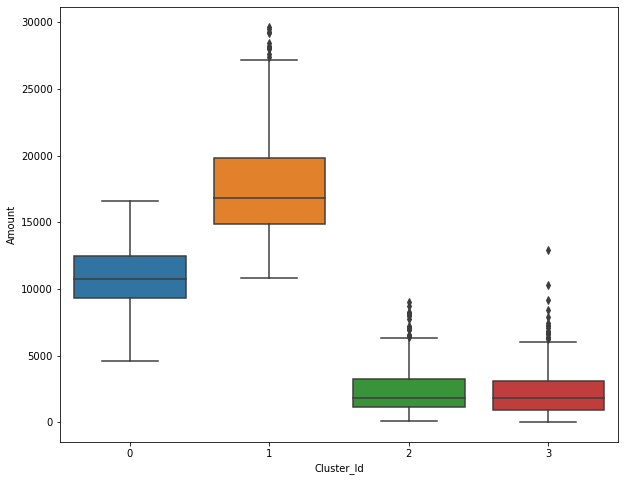

In [135]:
# Box plot to visualize Cluster Id vs Amount

sns.boxplot(x='Cluster_Id', y='Amount', data=rfm)

<AxesSubplot:xlabel='Cluster_Id', ylabel='Recency'>

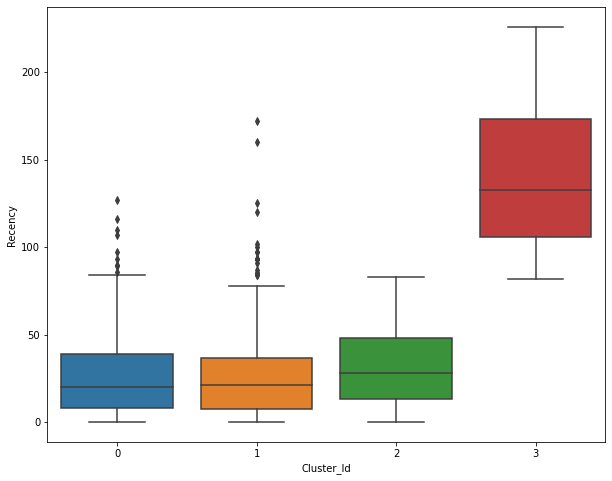

In [136]:
# Box plot to visualize Cluster Id vs Recency

sns.boxplot(x='Cluster_Id', y='Recency', data=rfm)

In [56]:
# Profit column
profit_column = orders.groupby('City')['Profit'].sum()
profit_column = profit_column.reset_index()
profit_column.columns = ['City', 'Profit']
profit_column.head()

,City,Profit
0,Aachen,1116.981
1,Aalen,283.005
2,Aalst,152.310
3,Aba,-1475.556
4,Abadan,233.820


<AxesSubplot:xlabel='Cluster_Id', ylabel='Frequency'>

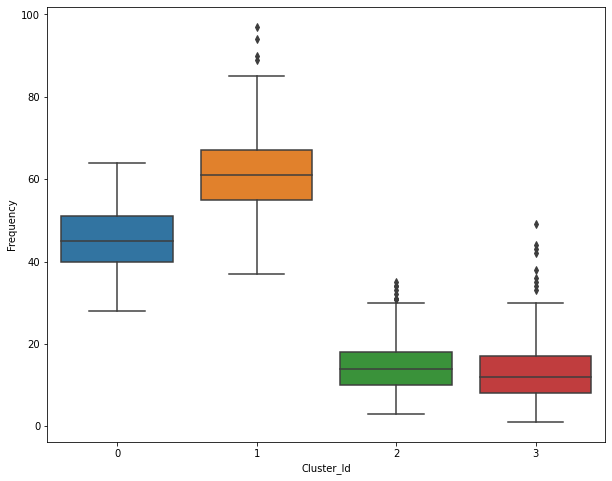

In [137]:
# Box plot to visualize Cluster Id vs Frequency

sns.boxplot(x='Cluster_Id', y='Frequency', data=rfm)

In [57]:
# Sales column
sales_column = orders.groupby('City')['Sales'].sum()
sales_column = sales_column.reset_index()
sales_column.columns = ['City', 'Sales']
sales_column.head()

,City,Sales
0,Aachen,3803.151
1,Aalen,979.695
2,Aalst,387.330
3,Aba,1064.124
4,Abadan,1354.950


In [58]:
# Shipping Cost column
shippingCost_column = orders.groupby('City')['Shipping Cost'].sum()
shippingCost_column = shippingCost_column.reset_index()
shippingCost_column.columns = ['City', 'ShippingCost']
shippingCost_column.head()

,City,ShippingCost
0,Aachen,391.28
1,Aalen,81.97
2,Aalst,30.19
3,Aba,122.45
4,Abadan,116.22


In [59]:
# Merging dataframes
profit_sales = pd.merge(profit_column, sales_column, on='City', how='inner')
profit_sales_shippingCost = pd.merge(profit_sales, shippingCost_column, on='City', how='inner')
profit_sales_shippingCost.columns = ['City', 'Profit', 'Sales', 'ShippingCost']
profit_sales_shippingCost.head()

,City,Profit,Sales,ShippingCost
0,Aachen,1116.981,3803.151,391.28
1,Aalen,283.005,979.695,81.97
2,Aalst,152.310,387.330,30.19
3,Aba,-1475.556,1064.124,122.45
4,Abadan,233.820,1354.950,116.22


Text(0.5, 0, 'Attributes')

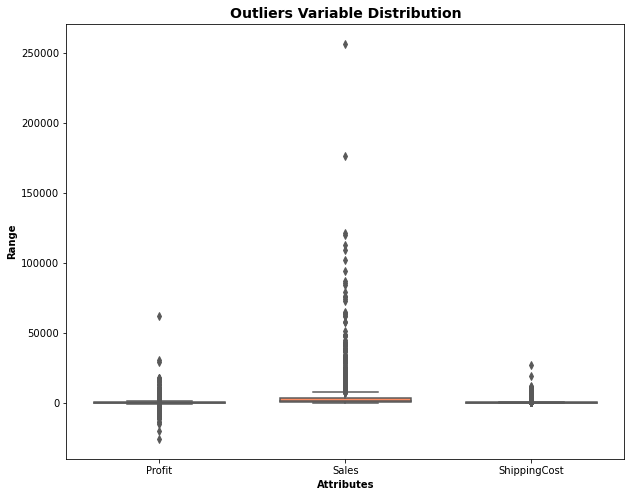

In [60]:
# Detect outliers

attributes = ['Profit','Sales','ShippingCost']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = profit_sales_shippingCost[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

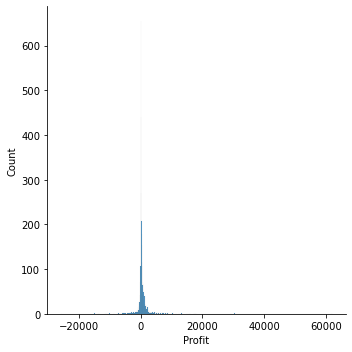

In [61]:
sns.displot(profit_sales_shippingCost['Profit'])

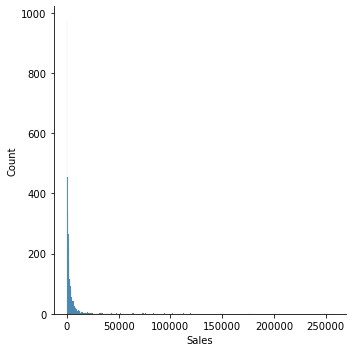

In [62]:
sns.displot(profit_sales_shippingCost['Sales'])

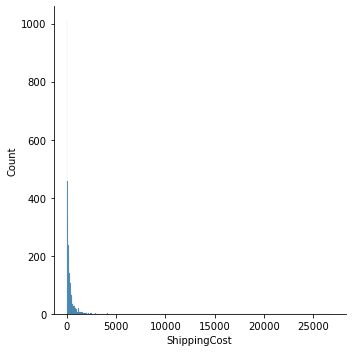

In [63]:
sns.displot(profit_sales_shippingCost['ShippingCost'])

In [64]:
# Removing (statistical) outliers for Sales
Q1 = profit_sales_shippingCost.Sales.quantile(0.25)
Q3 = profit_sales_shippingCost.Sales.quantile(0.75)
IQR = Q3 - Q1
rfm = profit_sales_shippingCost[(profit_sales_shippingCost.Sales >= Q1 - 1.5*IQR) & (profit_sales_shippingCost.Sales <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Shipping Cost
Q1 = profit_sales_shippingCost.ShippingCost.quantile(0.25)
Q3 = profit_sales_shippingCost.ShippingCost.quantile(0.75)
IQR = Q3 - Q1
rfm = profit_sales_shippingCost[(profit_sales_shippingCost.ShippingCost >= Q1 - 1.5*IQR) & (profit_sales_shippingCost.ShippingCost <= Q3 + 1.5*IQR)]

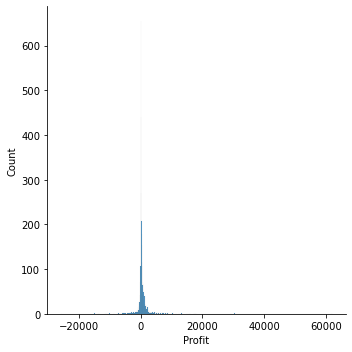

In [68]:
sns.displot(profit_sales_shippingCost['Profit'])

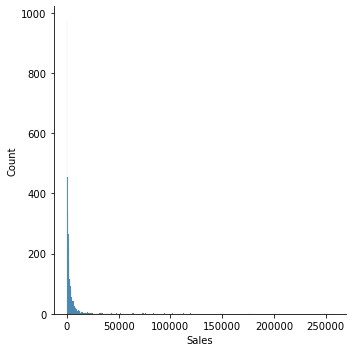

In [69]:
sns.displot(profit_sales_shippingCost['Sales'])

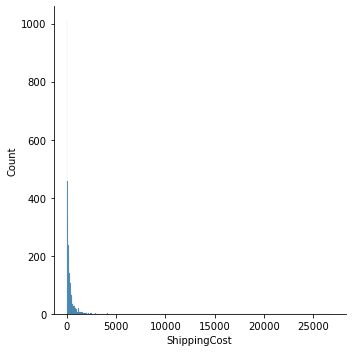

In [70]:
sns.displot(profit_sales_shippingCost['ShippingCost'])

In [71]:
# Rescaling the attributes

psc = profit_sales_shippingCost[['Profit', 'Sales', 'ShippingCost']]

# Instantiate
scaler = MinMaxScaler()

# fit_transform
psc_scaled = scaler.fit_transform(psc)
psc_scaled.shape

(3636, 3)

In [72]:
psc_scaled = pd.DataFrame(psc_scaled)
psc_scaled.columns = ['Profit', 'Sales', 'ShippingCost']
psc_scaled.head()

,Profit,Sales,ShippingCost
0,0.307408,0.014829,0.014516
1,0.297927,0.003816,0.003038
2,0.296441,0.001505,0.001117
3,0.277934,0.004145,0.004541
4,0.297368,0.005280,0.004309


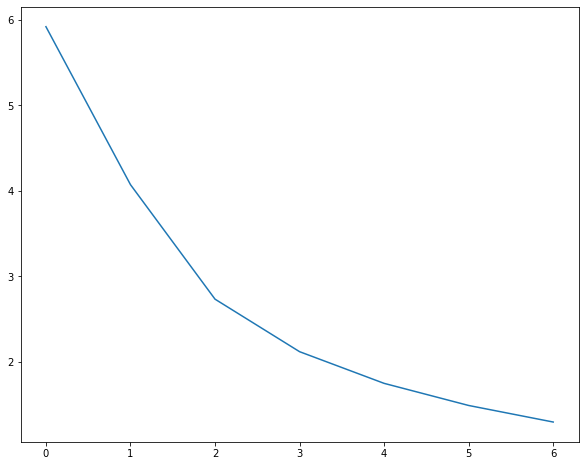

In [82]:
# Elbow-curve/SSD

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(psc_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)
# y-axis: SSD
# x-axis: Number of clusters
# Choose a balance point to avoid over-fitting.

In [74]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(psc_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(psc_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    
# The higher the point, the higher similarities between items within a cluster and 
# the higher dissimilarites bettwen items in different clusters.
# Choose a balance number to avoid over-fitting.

For n_clusters=2, the silhouette score is 0.9303563385577867
For n_clusters=3, the silhouette score is 0.8269138349788746
For n_clusters=4, the silhouette score is 0.8209412031525711
For n_clusters=5, the silhouette score is 0.6874964278579797
For n_clusters=6, the silhouette score is 0.6858495044441605
For n_clusters=7, the silhouette score is 0.6341560670107843
For n_clusters=8, the silhouette score is 0.6256592573903373


In [75]:
# Final model with k=4
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(psc_scaled)

KMeans(max_iter=50, n_clusters=4)

In [76]:
 kmeans.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [77]:
# assign the label
psc['Cluster_Id'] = kmeans.labels_
psc.head()

,Profit,Sales,ShippingCost,Cluster_Id
0,1116.981,3803.151,391.28,0
1,283.005,979.695,81.97,0
2,152.310,387.330,30.19,0
3,-1475.556,1064.124,122.45,0
4,233.820,1354.950,116.22,0


<AxesSubplot:xlabel='Cluster_Id', ylabel='Profit'>

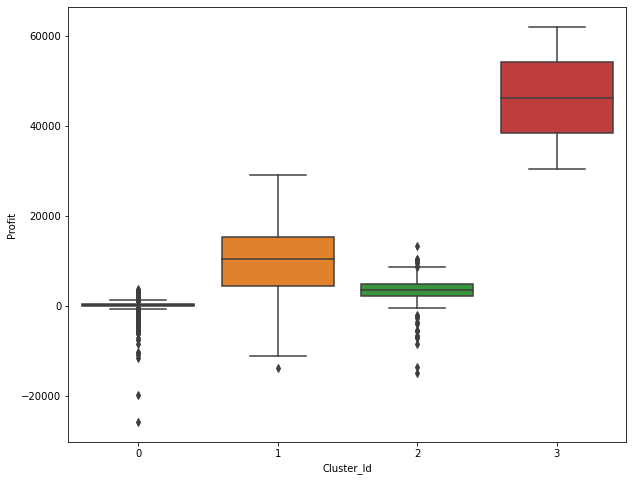

In [78]:
# Box plot to visualize Cluster Id vs Profit

sns.boxplot(x='Cluster_Id', y='Profit', data=psc)

<AxesSubplot:xlabel='Cluster_Id', ylabel='Sales'>

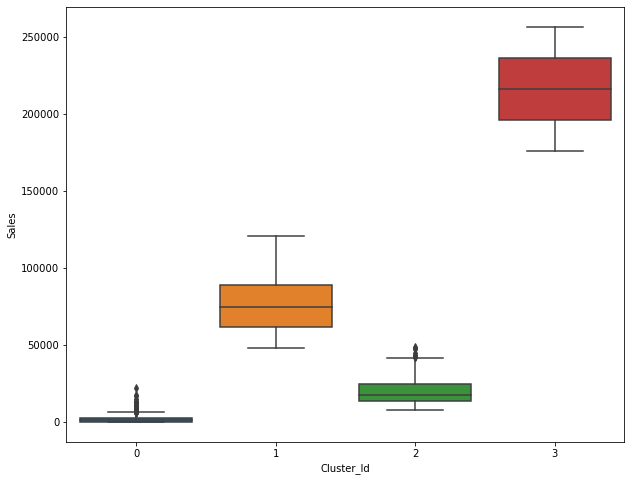

In [79]:
# Box plot to visualize Cluster Id vs Sales

sns.boxplot(x='Cluster_Id', y='Sales', data=psc)

<AxesSubplot:xlabel='Cluster_Id', ylabel='ShippingCost'>

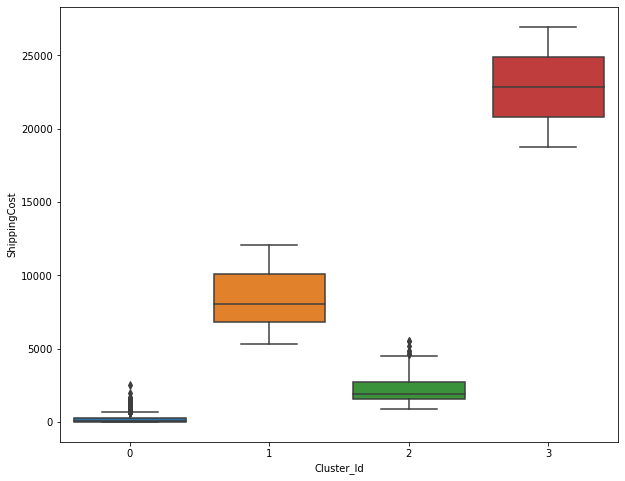

In [80]:
# Box plot to visualize Cluster Id vs Shipping Cost

sns.boxplot(x='Cluster_Id', y='ShippingCost', data=psc)

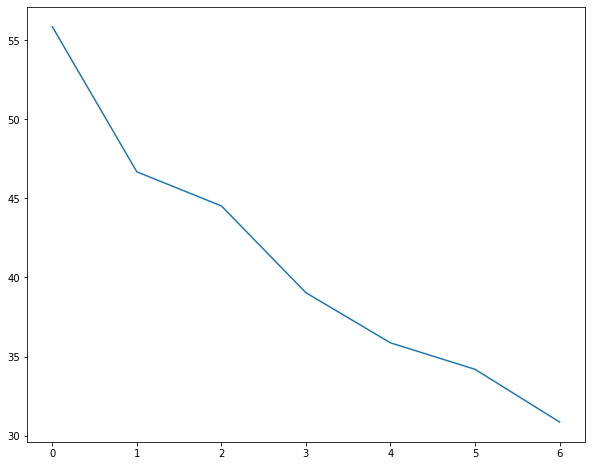

In [83]:
# Elbow-curve/SSD

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmedoids = KMedoids(n_clusters=num_clusters, max_iter=50)
    kmedoids.fit(psc_scaled)
    
    ssd.append(kmedoids.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)
# y-axis: SSD
# x-axis: Number of clusters
# Choose a balance point to avoid over-fitting.

In [84]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmedoids = KMedoids(n_clusters=num_clusters, max_iter=50)
    kmedoids.fit(psc_scaled)
    
    cluster_labels = kmedoids.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(psc_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    
# The higher the point, the higher similarities between items within a cluster and 
# the higher dissimilarites bettwen items in different clusters.
# Choose a balance number to avoid over-fitting.

For n_clusters=2, the silhouette score is 0.6021576475776785
For n_clusters=3, the silhouette score is 0.5318574423477032
For n_clusters=4, the silhouette score is 0.5477783791102391
For n_clusters=5, the silhouette score is 0.4579673477513966
For n_clusters=6, the silhouette score is 0.36983380043298664
For n_clusters=7, the silhouette score is 0.3072225525408161
For n_clusters=8, the silhouette score is 0.3017799544693868


In [86]:
# Final model with k=4
kmedoids = KMedoids(n_clusters=4, max_iter=50)
kmedoids.fit(psc_scaled)

KMedoids(max_iter=50, n_clusters=4)

In [87]:
# assign the label
psc['Cluster_Id'] = kmedoids.labels_
psc.head()

,Profit,Sales,ShippingCost,Cluster_Id
0,1116.981,3803.151,391.28,0
1,283.005,979.695,81.97,1
2,152.310,387.330,30.19,1
3,-1475.556,1064.124,122.45,2
4,233.820,1354.950,116.22,1


<AxesSubplot:xlabel='Cluster_Id', ylabel='Profit'>

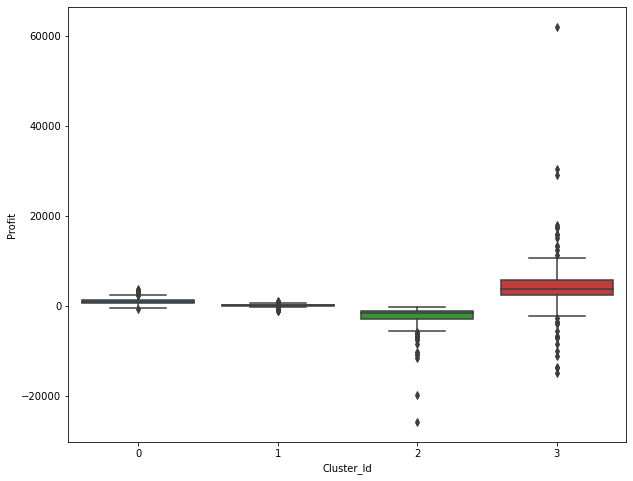

In [88]:
# Box plot to visualize Cluster Id vs Profit

sns.boxplot(x='Cluster_Id', y='Profit', data=psc)

<AxesSubplot:xlabel='Cluster_Id', ylabel='Sales'>

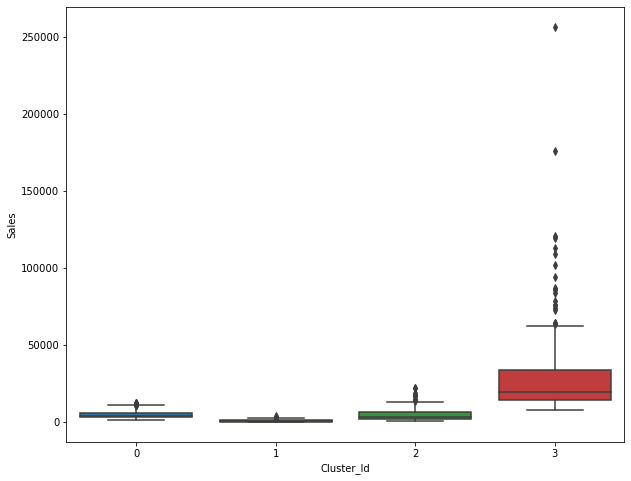

In [89]:
# Box plot to visualize Cluster Id vs Sales

sns.boxplot(x='Cluster_Id', y='Sales', data=psc)

<AxesSubplot:xlabel='Cluster_Id', ylabel='ShippingCost'>

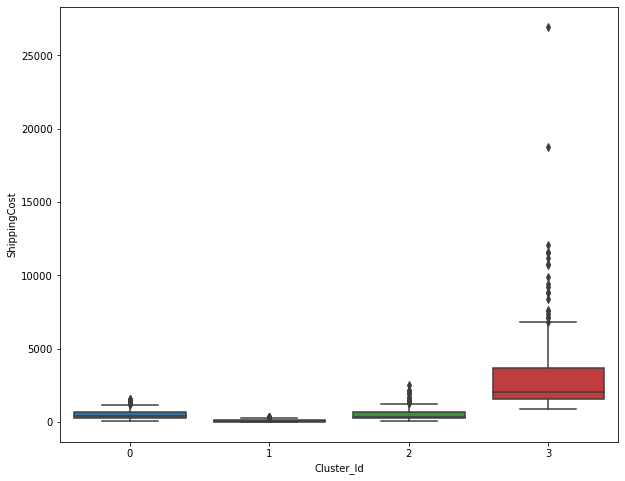

In [90]:
# Box plot to visualize Cluster Id vs Shipping Cost

sns.boxplot(x='Cluster_Id', y='ShippingCost', data=psc)

In [16]:
categoricals = orders.loc[:, ['City', 'Category', 'Profit']].copy() 

In [17]:
categoricals

,City,Category,Profit
0,Constantine,Office Supplies,106.1400
1,Wagga Wagga,Office Supplies,36.0360
2,Budapest,Office Supplies,29.6400
3,Stockholm,Office Supplies,-26.0550
4,Wagga Wagga,Furniture,37.7700
...,...,...,...
51285,Fairfield,Office Supplies,4.5188
51286,Agadir,Office Supplies,0.4200
51287,Managua,Office Supplies,12.3600
51288,Juárez,Office Supplies,0.5600


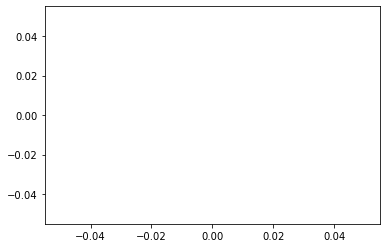

In [19]:
# Choose optimal K using Elbow method
ssd = []
for cluster in range(1, 10):
    try:
        kprototype = KPrototypes(n_clusters = cluster, init = 'Huang', random_state = 0, max_iter=50)
        kprototype.fit_predict(categoricals, categorical = [0, 1])
        ssd.append(kprototype.inertia_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break
# Converting the results into a dataframe and plotting them
plt.plot(ssd)